In [44]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE=360
BATCH_SIZE=10
CHANNELS=3
EPOCHS=40

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Lemon fruit disease dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 50 files belonging to 4 classes.


In [9]:
class_name=dataset.class_names
class_name

['Healthy lemons', 'Lemon Canker', 'Lemon scab', 'Mold']

In [10]:
len(dataset)

5

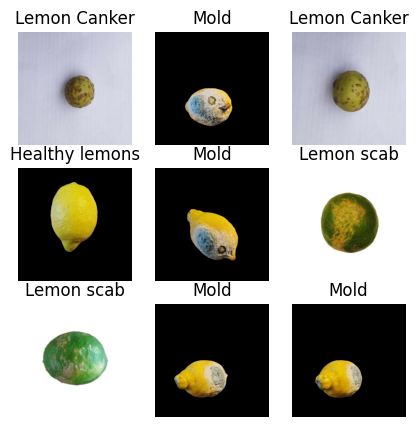

In [11]:
for image_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(5,5))
    for i in range(9): 
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

5

In [13]:
train_size=0.6
len(dataset)*train_size

3.0

In [14]:
train_ds=dataset.take(3)
len(train_ds)


3

In [15]:
test_ds=dataset.skip(4) 
len(test_ds)

1

In [16]:
val = 0.2
len(dataset)*val

1.0

In [17]:
val_ds=dataset.take(1)
len(val_ds)

1

In [18]:
def get_dataset_partitions_tf(ds, train_percent=0.6, val_percent=0.2, test_percent=0.2, shuffle=True, shuffle_buffer_size=10000):
    ds_size = len(ds)
    train_size = int(train_percent * ds_size)
    val_size = int(val_percent * ds_size)
    test_size = int(test_percent * ds_size)
    if shuffle:
        ds = ds.shuffle(shuffle_buffer_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

3

In [21]:
len(val_ds)

1

In [22]:
len(test_ds)

1

In [23]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./360)
])

In [25]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4

model=tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
])
model.build(input_shape=input_shape)
    

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10, 360, 360, 3)         0         
                                                                 
 sequential_1 (Sequential)   (10, 360, 360, 3)         0         
                                                                 
 conv2d (Conv2D)             (10, 358, 358, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (10, 179, 179, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (10, 177, 177, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (10, 88, 88, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [29]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/40
3/3 [==============================] - 6s 1s/step - loss: 1.3591 - accuracy: 0.4000 - val_loss: 1.0159 - val_accuracy: 0.6000
Epoch 2/40
3/3 [==============================] - 4s 1s/step - loss: 1.0260 - accuracy: 0.6333 - val_loss: 0.6838 - val_accuracy: 0.6000
Epoch 3/40
3/3 [==============================] - 4s 1s/step - loss: 0.8021 - accuracy: 0.6333 - val_loss: 0.7143 - val_accuracy: 0.6000
Epoch 4/40
3/3 [==============================] - 4s 1s/step - loss: 0.5574 - accuracy: 0.7000 - val_loss: 0.4490 - val_accuracy: 0.9000
Epoch 5/40
3/3 [==============================] - 4s 1s/step - loss: 0.4928 - accuracy: 0.8000 - val_loss: 0.5452 - val_accuracy: 0.7000
Epoch 6/40
3/3 [==============================] - 3s 1s/step - loss: 0.4807 - accuracy: 0.7333 - val_loss: 0.5846 - val_accuracy: 0.7000
Epoch 7/40
3/3 [==============================] - 3s 1s/step - loss: 0.5285 - accuracy: 0.7333 - val_loss: 0.3028 - val_accuracy: 0.9000
Epoch 8/40
3/3 [=========================

In [30]:
scores=model.evaluate(test_ds)

1/1 [==============================] - 0s 347ms/step - loss: 0.0107 - accuracy: 1.0000


In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 3}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

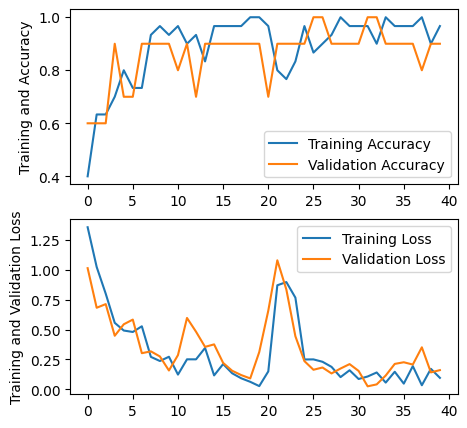

In [35]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Training and Accuracy")

plt.subplot(2,1,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Training and Validation Loss")
plt.show()

First img to predict
First img actual label:  Lemon Canker
1/1 [==============================] - 0s 184ms/step
Predicted Label:  Lemon Canker


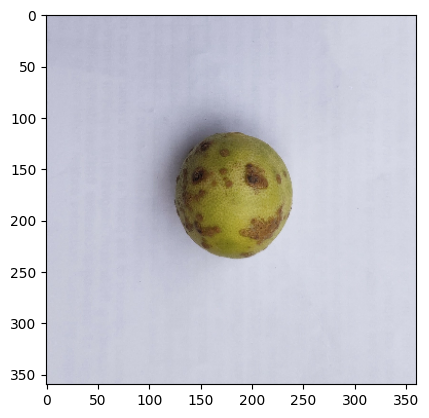

In [36]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_img=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()
    print('First img to predict')
    plt.imshow(first_img)
    print('First img actual label: ',class_name[first_label])
    model.predict(image_batch)
    batch_pred=model.predict(image_batch)
    print("Predicted Label: ",class_name[np.argmax(batch_pred[0])])

In [37]:
def predict(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_arr=tf.expand_dims(img_arr,0)
    predictions=model.predict(img_arr)
    predicted_class=class_name[np.argmax(predictions[0])]
    confidence=round(100*np.max(predictions[0]),2)
    return predicted_class,confidence

99.93
1/1 [==============================] - 0s 45ms/step
93.79
1/1 [==============================] - 0s 50ms/step
99.95
1/1 [==============================] - 0s 55ms/step
97.73
1/1 [==============================] - 0s 51ms/step
100.0
1/1 [==============================] - 0s 43ms/step
99.98
1/1 [==============================] - 0s 46ms/step
99.96
1/1 [==============================] - 0s 48ms/step
99.59
1/1 [==============================] - 0s 46ms/step
100.0
1/1 [==============================] - 0s 52ms/step


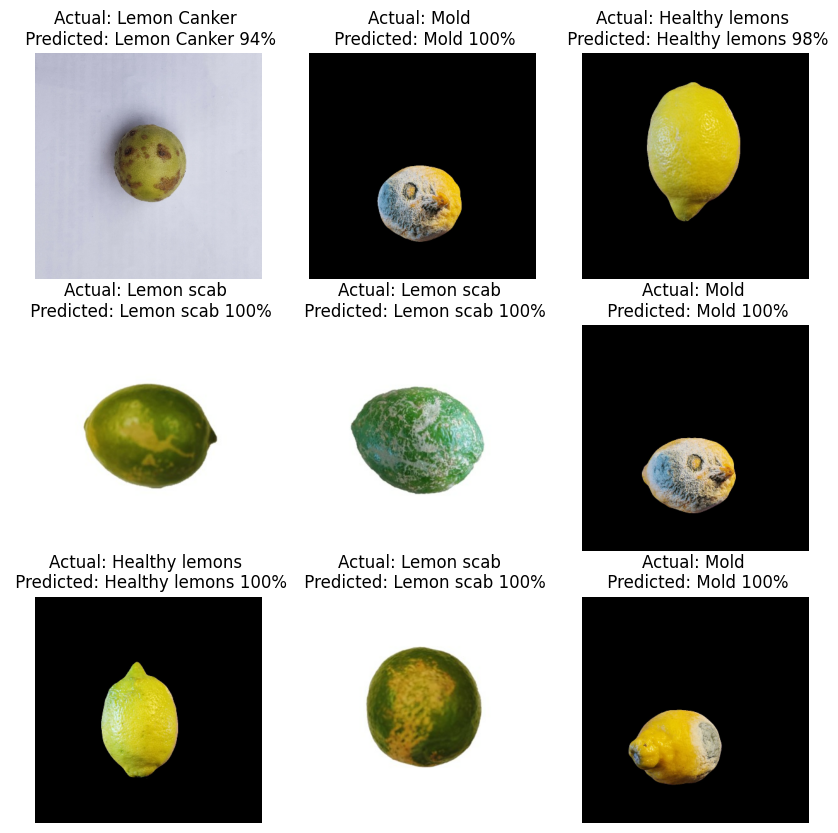

In [43]:
for images,labels in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        print(confidence)
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images)
        Actual_class=class_name[labels[i]]
        plt.title("Actual: {} \n Predicted: {} {:2.0f}%".format(Actual_class,predicted_class,confidence))
        plt.axis("off")